In [ ]:
# ============================================================================
# KLASIFIKASI DATA LSTM
# ============================================================================

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:00


In [4]:
# Text preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.tokenize import word_tokenize

In [5]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.layers import SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [7]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.7 MB/s eta 0:00:00


In [8]:
# Word embeddings
from gensim.models import Word2Vec
import gensim.downloader as api

In [9]:
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [10]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
import pandas as pd

print("\n[1] Loading Data...")

df_positif = pd.read_csv(
    'komentar_positif.csv',
    engine='python',
    sep=None,
    header=None,
    names=['komentar'],
    on_bad_lines='skip'
)

df_negatif = pd.read_csv(
    'komentar_negatif.csv',
    engine='python',
    sep=None,
    header=None,
    names=['komentar'],
    on_bad_lines='skip'
)

df_netral = pd.read_csv(
    'komentar_netral.csv',
    engine='python',
    sep=None,
    header=None,
    names=['komentar'],
    on_bad_lines='skip'
)

df_positif['label'] = 'positif'
df_negatif['label'] = 'negatif'
df_netral['label']  = 'netral'

df = pd.concat([df_positif, df_negatif, df_netral], ignore_index=True)

print("Total data:", len(df))
print(df['label'].value_counts())


[1] Loading Data...
Total data: 206
label
negatif    79
positif    75
netral     52
Name: count, dtype: int64


In [24]:
import pandas as pd

# Load data
df = pd.concat([
    pd.read_csv('komentar_negatif.csv', sep=';').assign(label='negatif'),
    pd.read_csv('komentar_netral.csv',  sep=';').assign(label='netral'),
    pd.read_csv('komentar_positif.csv', sep=';').assign(label='positif')
], axis=0).reset_index(drop=True)

# Cek data
print(df.head())
print(df.info())
print(df['label'].value_counts())

                                             comment    label
0  Over capacity ko masih impor, logikanya dimana...  negatif
1  Pak prabowo tolong ganti mentri esdm, bahlil h...  negatif
2  Bahlil...bahlil..sdh tdk percaya dgn manusia2 ...  negatif
3  Jebolan ITB lawan jebolan yg kampusnya nggak a...  negatif
4  Maaf dana nya abis di pake korupsi, ngak bangu...  negatif
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  300 non-null    object
 1   label    300 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB
None
label
negatif    100
netral     100
positif    100
Name: count, dtype: int64


In [25]:
# ============================================================================
# BAGIAN 2: TEXT PREPROCESSING
# ============================================================================

print("\n[2] Text Preprocessing...")

# Initialize Sastrawi
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

factory_stopword = StopWordRemoverFactory()
stopword_remover = factory_stopword.create_stop_word_remover()

def clean_text(text):
    """Cleaning text"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    """Full preprocessing"""
    text = clean_text(text)
    text = stopword_remover.remove(text)
    text = stemmer.stem(text)
    return text

df['comment_processed'] = df['comment'].apply(preprocess_text)

print("   ✓ Preprocessing selesai!")


[2] Text Preprocessing...
   ✓ Preprocessing selesai!


In [26]:
# ============================================================================
# BAGIAN 3: ENCODE LABELS
# ============================================================================

print("\n[3] Encoding Labels...")

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("   Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {label} -> {i}")

# Convert to categorical (one-hot encoding)
num_classes = len(label_encoder.classes_)
y = to_categorical(df['label_encoded'], num_classes=num_classes)


[3] Encoding Labels...
   Label mapping:
   negatif -> 0
   netral -> 1
   positif -> 2


In [27]:
# ============================================================================
# BAGIAN 4: TOKENIZATION & PADDING
# ============================================================================

print("\n[4] Tokenization & Padding...")

# Parameters
MAX_WORDS = 5000  # Vocabulary size
MAX_LEN = 100     # Maximum sequence length

# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['comment_processed'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['comment_processed'])

# Padding
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"   Vocabulary size: {len(tokenizer.word_index)}")
print(f"   Max sequence length: {MAX_LEN}")
print(f"   Shape of X: {X.shape}")
print(f"   Shape of y: {y.shape}")


[4] Tokenization & Padding...
   Vocabulary size: 1126
   Max sequence length: 100
   Shape of X: (300, 100)
   Shape of y: (300, 3)


In [28]:
# ============================================================================
# BAGIAN 5: SPLIT DATA
# ============================================================================

print("\n[5] Splitting Data (80% Train, 20% Test)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['label_encoded']
)

# Untuk confusion matrix nanti
y_test_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

print(f"   Training data: {len(X_train)}")
print(f"   Testing data: {len(X_test)}")


[5] Splitting Data (80% Train, 20% Test)...
   Training data: 240
   Testing data: 60


In [29]:
# ============================================================================
# BAGIAN 6: MODEL ARCHITECTURES
# ============================================================================

results = []
histories = {}

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

print("\n" + "="*80)
print("LSTM MODEL TRAINING")
print("="*80)


LSTM MODEL TRAINING


In [30]:
# ----------------------------------------------------------------------------
# 6.1 LSTM with Simple Embedding
# ----------------------------------------------------------------------------

print("\n[6.1] LSTM with Simple Embedding Layer")
print("-" * 50)

model_simple = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n   Model Summary:")
model_simple.build(input_shape=(None, MAX_LEN))
model_simple.summary()

print("\n   Training...")
history_simple = model_simple.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_simple = model_simple.predict(X_test, verbose=0)
y_pred_simple_classes = np.argmax(y_pred_simple, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

acc_simple = accuracy_score(y_test_classes, y_pred_simple_classes)
print(f"\n   Test Accuracy: {acc_simple:.4f}")

print("\n   Classification Report:")
print(classification_report(
    label_encoder.inverse_transform(y_test_classes),
    label_encoder.inverse_transform(y_pred_simple_classes)
))

results.append({
    'Model': 'LSTM Simple',
    'Accuracy': acc_simple,
    'Val_Accuracy': max(history_simple.history['val_accuracy'])
})
histories['LSTM Simple'] = history_simple

# Save model
model_simple.save('lstm_simple_model.h5')
print("   ✓ Model saved: lstm_simple_model.h5")


[6.1] LSTM with Simple Embedding Layer
--------------------------------------------------

   Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,587 (2.64 MB)

 Trainable params: 691,587 (2.64 MB)

 Non-trainable params: 0 (0.00 B)


   Training...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.3519 - loss: 1.0995 - val_accuracy: 0.3333 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.3579 - loss: 1.0982 - val_accuracy: 0.3333 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.3161 - loss: 1.0948 - val_accuracy: 0.3333 - val_loss: 1.1015 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3536 - loss: 1.0971 - val_accuracy: 0.3333 - val_loss: 1.1015 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.3324 - loss: 1.0993 - val_accuracy: 0.3333 - val_loss: 1.1012 - learning_rate: 5.0000e-04
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.3075 - loss: 1.1052 - val_accuracy: 0.3333 - val_loss: 1.1004 - learning_rate: 5.0000e-04



   Test Accuracy: 0.3333

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        20
      netral       0.00      0.00      0.00        20
     positif       0.33      1.00      0.50        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60

   ✓ Model saved: lstm_simple_model.h5


In [31]:
# ----------------------------------------------------------------------------
# 6.2 Bidirectional LSTM
# ----------------------------------------------------------------------------

print("\n[6.2] Bidirectional LSTM")
print("-" * 50)

model_bilstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_bilstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n   Model Summary:")
model_bilstm.build(input_shape=(None, MAX_LEN))
model_bilstm.summary()

print("\n   Training...")
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_bilstm = model_bilstm.predict(X_test, verbose=0)
y_pred_bilstm_classes = np.argmax(y_pred_bilstm, axis=1)

acc_bilstm = accuracy_score(y_test_classes, y_pred_bilstm_classes)
print(f"\n   Test Accuracy: {acc_bilstm:.4f}")

print("\n   Classification Report:")
print(classification_report(
    label_encoder.inverse_transform(y_test_classes),
    label_encoder.inverse_transform(y_pred_bilstm_classes)
))

results.append({
    'Model': 'Bidirectional LSTM',
    'Accuracy': acc_bilstm,
    'Val_Accuracy': max(history_bilstm.history['val_accuracy'])
})
histories['Bidirectional LSTM'] = history_bilstm

# Save model
model_bilstm.save('lstm_bidirectional_model.h5')
print("   ✓ Model saved: lstm_bidirectional_model.h5")


[6.2] Bidirectional LSTM
--------------------------------------------------

   Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 743,043 (2.83 MB)

 Trainable params: 743,043 (2.83 MB)

 Non-trainable params: 0 (0.00 B)


   Training...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.2954 - loss: 1.1014 - val_accuracy: 0.4375 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.3606 - loss: 1.0926 - val_accuracy: 0.5208 - val_loss: 1.0927 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3427 - loss: 1.0957 - val_accuracy: 0.5625 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4680 - loss: 1.0766 - val_accuracy: 0.5833 - val_loss: 1.0755 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4221 - loss: 1.0800 - val_accuracy: 0.5625 - val_loss: 1.0663 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6207 - loss: 1.0247 - val_accuracy: 0.5208 - val_loss: 1.0493 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5941 - loss: 0.9519 


   Test Accuracy: 0.6167

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.54      0.65      0.59        20
      netral       0.52      0.65      0.58        20
     positif       1.00      0.55      0.71        20

    accuracy                           0.62        60
   macro avg       0.69      0.62      0.63        60
weighted avg       0.69      0.62      0.63        60

   ✓ Model saved: lstm_bidirectional_model.h5


In [32]:
# ----------------------------------------------------------------------------
# 6.3 Stacked LSTM
# ----------------------------------------------------------------------------

print("\n[6.3] Stacked LSTM (2 Layers)")
print("-" * 50)

model_stacked = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_stacked.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n   Model Summary:")
model_stacked.build(input_shape=(None, MAX_LEN))
model_stacked.summary()

print("\n   Training...")
history_stacked = model_stacked.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_stacked = model_stacked.predict(X_test, verbose=0)
y_pred_stacked_classes = np.argmax(y_pred_stacked, axis=1)

acc_stacked = accuracy_score(y_test_classes, y_pred_stacked_classes)
print(f"\n   Test Accuracy: {acc_stacked:.4f}")

print("\n   Classification Report:")
print(classification_report(
    label_encoder.inverse_transform(y_test_classes),
    label_encoder.inverse_transform(y_pred_stacked_classes)
))

results.append({
    'Model': 'Stacked LSTM',
    'Accuracy': acc_stacked,
    'Val_Accuracy': max(history_stacked.history['val_accuracy'])
})
histories['Stacked LSTM'] = history_stacked

# Save model
model_stacked.save('lstm_stacked_model.h5')
print("   ✓ Model saved: lstm_stacked_model.h5")


[6.3] Stacked LSTM (2 Layers)
--------------------------------------------------

   Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 702,979 (2.68 MB)

 Trainable params: 702,979 (2.68 MB)

 Non-trainable params: 0 (0.00 B)


   Training...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.3499 - loss: 1.1009 - val_accuracy: 0.3750 - val_loss: 1.0964 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.2740 - loss: 1.1095 - val_accuracy: 0.2917 - val_loss: 1.0992 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.3342 - loss: 1.0975 - val_accuracy: 0.2917 - val_loss: 1.1028 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4048 - loss: 1.0964 - val_accuracy: 0.2917 - val_loss: 1.1035 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.3295 - loss: 1.1027 - val_accuracy: 0.2917 - val_loss: 1.1038 - learning_rate: 5.0000e-04
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3555 - loss: 1.0915 - val_accuracy: 0.2917 - val_loss: 1.1037 - learning_rate: 5.0000e-04



   Test Accuracy: 0.3333

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.33      1.00      0.50        20
      netral       0.00      0.00      0.00        20
     positif       0.00      0.00      0.00        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60

   ✓ Model saved: lstm_stacked_model.h5


In [33]:
# ----------------------------------------------------------------------------
# 6.4 LSTM with Word2Vec Embeddings
# ----------------------------------------------------------------------------

print("\n[6.4] LSTM with Word2Vec Pre-trained Embeddings")
print("-" * 50)

# Tokenize untuk Word2Vec
texts_tokenized = [text.split() for text in df['comment_processed']]

# Train Word2Vec
print("   Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=texts_tokenized,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)

# Create embedding matrix
vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if idx < MAX_WORDS:
        try:
            embedding_matrix[idx] = w2v_model.wv[word]
        except KeyError:
            pass

print(f"   Embedding matrix shape: {embedding_matrix.shape}")

# Build model with pre-trained embeddings
model_w2v = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False  # Freeze embeddings
    ),
    SpatialDropout1D(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_w2v.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n   Model Summary:")
model_w2v.build(input_shape=(None, MAX_LEN))
model_w2v.summary()

print("\n   Training...")
history_w2v = model_w2v.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
y_pred_w2v = model_w2v.predict(X_test, verbose=0)
y_pred_w2v_classes = np.argmax(y_pred_w2v, axis=1)

acc_w2v = accuracy_score(y_test_classes, y_pred_w2v_classes)
print(f"\n   Test Accuracy: {acc_w2v:.4f}")

print("\n   Classification Report:")
print(classification_report(
    label_encoder.inverse_transform(y_test_classes),
    label_encoder.inverse_transform(y_pred_w2v_classes)
))

results.append({
    'Model': 'LSTM + Word2Vec',
    'Accuracy': acc_w2v,
    'Val_Accuracy': max(history_w2v.history['val_accuracy'])
})
histories['LSTM + Word2Vec'] = history_w2v

# Save model
model_w2v.save('lstm_word2vec_model.h5')
print("   ✓ Model saved: lstm_word2vec_model.h5")


[6.4] LSTM with Word2Vec Pre-trained Embeddings
--------------------------------------------------
   Training Word2Vec model...
   Embedding matrix shape: (1127, 100)

   Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │       112,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,119 (613.75 KB)

 Trainable params: 44,419 (173.51 KB)

 Non-trainable params: 112,700 (440.23 KB)


   Training...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.2388 - loss: 1.0991 - val_accuracy: 0.2917 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3112 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0993 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3401 - loss: 1.0992 - val_accuracy: 0.3333 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4079 - loss: 1.0964 - val_accuracy: 0.3333 - val_loss: 1.0995 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3007 - loss: 1.0991 - val_accuracy: 0.3333 - val_loss: 1.0997 - learning_rate: 5.0000e-04
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3804 - loss: 1.0968 - val_accuracy: 0.3333 - val_loss: 1.0999 - learning_rate: 5.0000e-04



   Test Accuracy: 0.3333

   Classification Report:
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        20
      netral       0.33      1.00      0.50        20
     positif       0.00      0.00      0.00        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60

   ✓ Model saved: lstm_word2vec_model.h5


In [34]:
# ============================================================================
# BAGIAN 7: COMPARISON & RESULTS
# ============================================================================

print("\n" + "="*80)
print("COMPARISON OF ALL LSTM MODELS")
print("="*80)

df_results = pd.DataFrame(results)
print("\n", df_results.to_string(index=False))

# Save results
df_results.to_csv('lstm_results.csv', index=False)
print("\n✓ Results saved to: lstm_results.csv")

# Best model
best_model = df_results.loc[df_results['Accuracy'].idxmax()]
print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"   Test Accuracy: {best_model['Accuracy']:.4f}")
print(f"   Val Accuracy: {best_model['Val_Accuracy']:.4f}")


COMPARISON OF ALL LSTM MODELS

              Model  Accuracy  Val_Accuracy
       LSTM Simple  0.333333      0.333333
Bidirectional LSTM  0.616667      0.625000
      Stacked LSTM  0.333333      0.375000
   LSTM + Word2Vec  0.333333      0.333333

✓ Results saved to: lstm_results.csv

🏆 Best Model: Bidirectional LSTM
   Test Accuracy: 0.6167
   Val Accuracy: 0.6250


In [35]:
# ============================================================================
# BAGIAN 8: VISUALIZATIONS
# ============================================================================

print("\n[8] Creating Visualizations...")


[8] Creating Visualizations...


   ✓ Saved: lstm_training_history.png


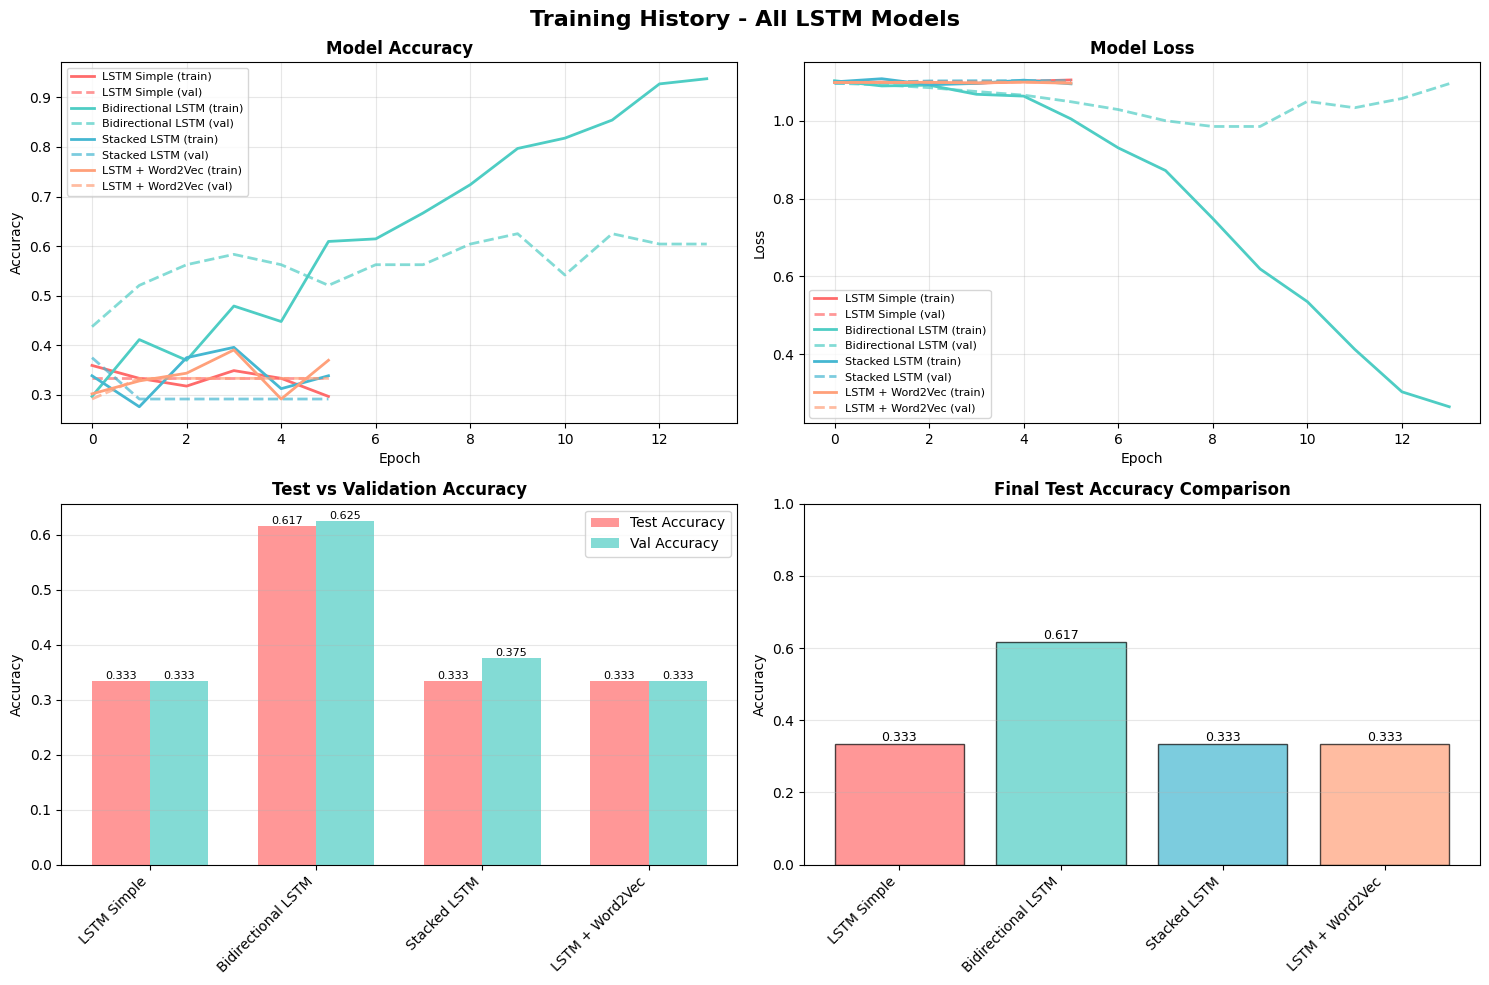

In [36]:
# 8.1 Training History - All Models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History - All LSTM Models', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Accuracy plots
ax1 = axes[0, 0]
for (name, history), color in zip(histories.items(), colors):
    ax1.plot(history.history['accuracy'], label=f'{name} (train)',
             color=color, linestyle='-', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label=f'{name} (val)',
             color=color, linestyle='--', linewidth=2, alpha=0.7)
ax1.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# Loss plots
ax2 = axes[0, 1]
for (name, history), color in zip(histories.items(), colors):
    ax2.plot(history.history['loss'], label=f'{name} (train)',
             color=color, linestyle='-', linewidth=2)
    ax2.plot(history.history['val_loss'], label=f'{name} (val)',
             color=color, linestyle='--', linewidth=2, alpha=0.7)
ax2.set_title('Model Loss', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# Comparison bar chart
ax3 = axes[1, 0]
x = np.arange(len(df_results))
width = 0.35
bars1 = ax3.bar(x - width/2, df_results['Accuracy'], width,
                label='Test Accuracy', color='#FF6B6B', alpha=0.7)
bars2 = ax3.bar(x + width/2, df_results['Val_Accuracy'], width,
                label='Val Accuracy', color='#4ECDC4', alpha=0.7)
ax3.set_title('Test vs Validation Accuracy', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy')
ax3.set_xticks(x)
ax3.set_xticklabels(df_results['Model'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Overall comparison
ax4 = axes[1, 1]
bars = ax4.bar(df_results['Model'], df_results['Accuracy'],
               color=colors, alpha=0.7, edgecolor='black')
ax4.set_title('Final Test Accuracy Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('Accuracy')
ax4.set_xticklabels(df_results['Model'], rotation=45, ha='right')
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: lstm_training_history.png")

   ✓ Saved: lstm_confusion_matrix.png


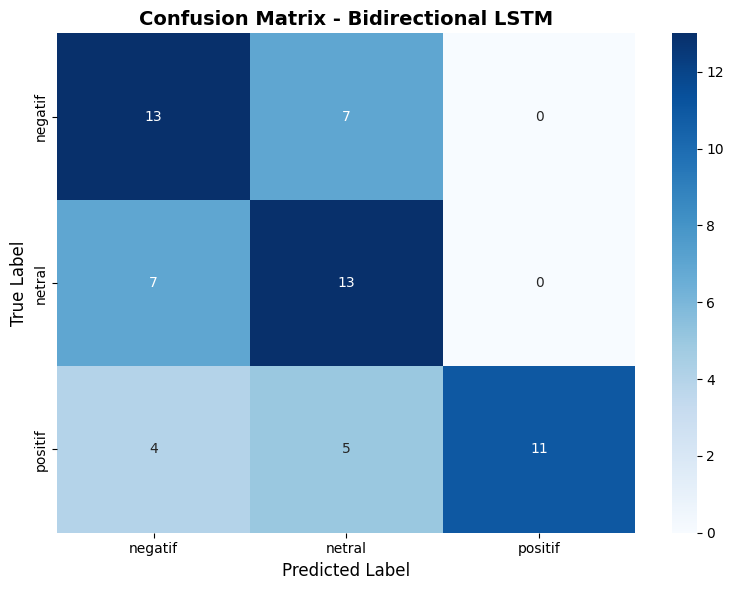

In [37]:
# 8.2 Confusion Matrix - Best Model (Bidirectional LSTM)
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(
    label_encoder.inverse_transform(y_test_classes),
    label_encoder.inverse_transform(y_pred_bilstm_classes)
)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=ax)
ax.set_title('Confusion Matrix - Bidirectional LSTM', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('lstm_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: lstm_confusion_matrix.png")

In [38]:
# ============================================================================
# BAGIAN 9: SAVE PREDICTIONS
# ============================================================================

print("\n[9] Saving Predictions...")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("LSTM CLASSIFICATION COMPLETED!")
print("="*80)

print("\n📁 Output Files:")
print("   1. lstm_results.csv - Performance comparison")
print("   2. lstm_predictions.csv - Predictions from all models")
print("   3. lstm_training_history.png - Training visualization")
print("   4. lstm_confusion_matrix.png - Confusion matrix")
print("   5. lstm_simple_model.h5 - Simple LSTM model")
print("   6. lstm_bidirectional_model.h5 - Bidirectional LSTM model")
print("   7. lstm_stacked_model.h5 - Stacked LSTM model")
print("   8. lstm_word2vec_model.h5 - LSTM + Word2Vec model")

print("\n📊 Best Model Summary:")
print(f"   Model: {best_model['Model']}")
print(f"   Test Accuracy: {best_model['Accuracy']:.4f}")
print(f"   Validation Accuracy: {best_model['Val_Accuracy']:.4f}")

print("\n" + "="*80)


[9] Saving Predictions...

LSTM CLASSIFICATION COMPLETED!

📁 Output Files:
   1. lstm_results.csv - Performance comparison
   2. lstm_predictions.csv - Predictions from all models
   3. lstm_training_history.png - Training visualization
   4. lstm_confusion_matrix.png - Confusion matrix
   5. lstm_simple_model.h5 - Simple LSTM model
   6. lstm_bidirectional_model.h5 - Bidirectional LSTM model
   7. lstm_stacked_model.h5 - Stacked LSTM model
   8. lstm_word2vec_model.h5 - LSTM + Word2Vec model

📊 Best Model Summary:
   Model: Bidirectional LSTM
   Test Accuracy: 0.6167
   Validation Accuracy: 0.6250

